The transfer function for the causal LTI system with a realization $(A, B, C, D)$ is given by
\begin{equation*}
    H(s) = C(sI_{n} - A)^{-1}B.
\end{equation*}
Notice that $H(s) = Cv(s)$, where $v(s)$ is the solution of a parametrized linear coercive model
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$. In other words, we replace the matrix computation of $(sI_{n} - A)^{-1}B$ with a parametrized model (1). However, if one wants to apply this to the Iterative rational Krylov algorithm (IRKA), then the following matrix computations must be done to construct the projection matrices $V$ and $W$:
\begin{equation*}
    (-\mu_{i}I_{n} - A)^{-1}B\hat{b}_{i}, \quad \text{and} \quad (-\mu_{i}I_{n} - A)^{-*}C^{T}\hat{c}_{i} \quad \text{for } i = 1,\ldots,r,
\end{equation*}
where $-\mu_{i}, \hat{c}_{i}, \hat{b}_{i}$ are some initial interpolation data and $0 < r \leq n$ is the desired order of approximating ROM. So, we have decided to solve two parametrized linear coercive models to construct projection matrices $V$ and $W$:
\begin{equation}
    a_{1}(v_{1}, w; s) = l_{1}(w) \quad \text{and} \quad a_{2}(v_{2}, w; s) = l_{2}(w),
\end{equation}
where $a_{1}(v_{1}, w; s) = w^{*}(sI_{n} - A)v_{1}$ and $l_{1}(w) = w^{*}B$, and $a_{2}(v_{2}, w; s) = w^{*}(sI_{n} - A)^{*}v_{2}$ and $l_{2}(w) = w^{*}C^{T}$, and solutions to these parametrized linear coercive models are
\begin{equation*}
    v_{1}(s) = (sI_{n} - A)^{-1}B \quad \text{and} \quad v_{2}(s) = (sI_{n} - A)^{-*}C^{T}.
\end{equation*}
Therefore, knowing $v_{1}(\mu_{i})$ and $v_{2}(\mu_{i})$ for $i = 1, \ldots, r$ will suffice for constructing the projection matrices $V$ and $W$. Also, note that these two FOMs are parameter-separable, i.e.,
\begin{equation*}
    a_{1}(v_{1},w;s) = w^{*}(sI_{n} - A)v_{1} = sw^{*}I_{n}v_{1} - w^{*}Av_{1}  \quad  a_{2}(v_{2},w;s) = w^{*}(sI_{n} - A)^{*}v_{2} = \overline{s}w^{*}I_{n}v_{2} - w^{*}A^{*}v_{2}.
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pymor.basic import *
from pymor.models.basic import StationaryModel
from pymor.operators.constructions import LincombOperator
from pymor.operators.numpy import NumpyMatrixOperator
from pymor.parameters.functionals import ProjectionParameterFunctional
from pymor.vectorarrays.numpy import NumpyVectorSpace

### Constructing a stationary model
Let us construct a stationary model of the following parametrized linear coercive model using `pyMOR`:
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$.

In [16]:
def MatrixModel(A, B, dim: int):

    '''
    This function create a stationary model of the following linear coercive model derived for the given two matrices A and B:
    
        a(v, w; s) =w^{*}(sI_{n} - A)v and l(w) = w^{*}B.
    '''
    
    # Define NumpyMatrixOperators
    I_op = NumpyMatrixOperator(np.eye(dim), source_id='STATE', range_id='STATE')

    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        A_op = NumpyMatrixOperator(A)
        B_op = NumpyMatrixOperator(B.reshape(-1, 1))
    else:
        A_op = A
        B_op = B       

    # Define parameter functional for 's'
    s_param = ProjectionParameterFunctional('s', 1)

    # Define bilinear form a(v, w; s) = w^* (sI - A)v
    a_op = LincombOperator([I_op, A_op], [s_param, -1])

    # Define linear functional l(w) = w^*B
    l_op = B_op

    # Define the StationaryModel
    model = StationaryModel(operator = a_op, rhs = l_op)

    return model

### Examples
Notice that to make this process more convenient, we provide two options for input matrices. If one has the matrices as `NumPy` arrays, they can import them directly without changing their type to work with `pyMOR`. Additionally, if one wants to input matrices from existing `pyMOR` models, this can also be done directly. To demonstrate this, we provide two examples: one with random matrices that we construct ourselves, and the other with matrices imported from the `penzl_example` in `pymor.models.examples`.


In [7]:
# Stationary model constructed using random numpy arrays
test_dim_random_model = 20

# Randomly generated arrays
np.random.seed(127)
matrixA = np.random.rand(test_dim_random_model, test_dim_random_model)
matrixB = B = np.random.rand(test_dim_random_model)

model_numpy = MatrixModel(A = matrixA, B = matrixB, dim = test_dim_random_model)
model_numpy

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={},
    output_d_mu_use_adjoint=True)

The model setup in this way is equivalent to solving the matrices directly:

In [8]:
# Set parameter for evaluation
parameter = {'s': 1.4}  # s = 1.4

# Solve the model
solution = model_numpy.solve(parameter).to_numpy()

# Exact matrix computation
exact = (inv(parameter['s']*np.eye(test_dim_random_model) - matrixA)@matrixB).reshape(1, test_dim_random_model)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The exact value of the matrix computation (1.4I - A)^{-1}B is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The L-infinity error is 2.6645352591003757e-15.


From now on, we will work with the `penzl_example`, which is implemented in `pymor.model.examples`


In [17]:
# Stationary model constructed using matrices obtained from penzl example
from pymor.models.examples import penzl_example

penzl = penzl_example()

model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)
model_penzl

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<1006x1006 dense>, source_id='STATE', range_id='STATE'),
         NumpyMatrixOperator(<1006x1006 sparse, 1012 nnz>, source_id='STATE', range_id='STATE')),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<1006x1 dense>, range_id='STATE'),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(1006, id='STATE')),
    products={},
    output_d_mu_use_adjoint=True)

As we will be interested in complex values inputs, the following computations shows that the computations above are also possible using a complex valued parameter space


In [18]:
from pymor.algorithms.to_matrix import to_matrix

# Set parameter for evaluation
parameter = {'s': -1 + 2*1j}  # s = - 1 + 2i

# Solve the model
solution = model_penzl.solve(parameter).to_numpy()

# Exact matrix computation
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

exact = (inv(parameter['s']*np.eye(penzl.order) - matrixA)@matrixB).reshape(1, penzl.order)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The exact value of the matrix computation ((-1+2j)I - A)^{-1}B is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The L-infinity error is 1.3877787807814457e-17.


## Reduced Basis Methods

As an example, we will use `penzl_example` from `pymor.models.examples` to construct a reduced basis using the reduced basis methods available in `pyMOR`.

### POD-Galerkin Method

As a first test, we restrict ourselves to the parameter space $\mathcal{P} = [0.01, 10] \subset \mathbb{R}$

In [25]:
from pymor.algorithms.pod import pod
from pymor.reductors.basic import StationaryRBReductor

# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a training set
training_size = 50
training_set = parameter_space.sample_randomly(training_size)

# Compute FOM solutions for the parameters in the training set
solution_snapshots = model_penzl.solution_space.empty()
for s in training_set:
    solution_snapshots.append(model_penzl.solve(s))

#Compute POD #TODO are the default tolerances of pymor okay for us?
pod_basis, singular_values = pod(solution_snapshots, rtol=0, atol=0)

# POD-Galerkin RB method
pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
pod_rom = pod_reductor.reduce()
pod_rom


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<14x14 dense>), NumpyMatrixOperator(<14x14 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<14x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(14)),
    products={},
    output_d_mu_use_adjoint=True,
    name='StationaryModel_reduced')

In [28]:
import time

# Start timing
start_time_reduce = time.time()

# Define a validation set
validation_size = 10
validation_set = parameter_space.sample_randomly(validation_size)

# Solution array containing r many reduced samples
reduced_solution = pod_rom.solution_space.empty()
for s in validation_set:
    reduced_solution.append(pod_rom.solve(s))

# Compute and print the elapsed time
elapsed_time_reduce = time.time() - start_time_reduce

# Reconstruct high-dimensional vector from reduced vector (necessary for error analysis)
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

##############################################################################################

# Start timing
start_time_full = time.time()

# FOM solution
full_solution = model_penzl.solution_space.empty()
for s in validation_set:
    full_solution.append(model_penzl.solve(s))
    
# End timing
end_time_full = time.time()

# Compute and print the elapsed time
elapsed_time_full = end_time_full - start_time_full

# Convert FOM solution into NumPy array
#TODO we can do all of this in pyMOR language
full_solution_numpy = full_solution.to_numpy()

# ROM solution
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()



Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Now we can compare the error of FOM and ROM as well as the computational times.

In [32]:

error_fom = full_solution_numpy - reduced_solution_reconstruct_numpy
num_rows = error_fom.shape[0]
linfnorm_fom = np.zeros(num_rows)
l2norm_fom = np.zeros(num_rows)

for row_number in range(num_rows):
    linfnorm_fom[row_number] = np.linalg.norm(error_fom[row_number], np.inf)
    l2norm_fom[row_number] = np.linalg.norm(error_fom[row_number])  

# Printing error results
print('-'*20 + ' Linf and L2 norms (array) of error vectors '+'-'*30)
print(f'The L-infinity norm of (FOM solution - ROM solution) is {linfnorm_fom}.')
print(f'The L-2 norm of (FOM solution - ROM solution) is {l2norm_fom}. \n')

# Computational time analysis (execution time analysis)
print(f'Total computation time of POD-Galerkin ROM: {elapsed_time_reduce:.10f} seconds.')
print(f'Total computation time of FOM: {elapsed_time_full:.10f} seconds.')

-------------------- Look below to check if things are going well ------------------------------
-------------------- Linf and L2 norms (array) of error vectors ------------------------------
The L-infinity norm of (FOM solution - ROM solution) is [1.31283873e-14 9.27036226e-15 8.28503932e-15 4.91690022e-14
 6.25888230e-15 2.60763633e-14 3.84314802e-12 6.31439345e-15
 1.52655666e-15 2.04558592e-14].
The L-2 norm of (FOM solution - ROM solution) is [2.04540795e-14 1.41743598e-14 1.33405998e-14 7.92082768e-14
 1.02734539e-14 4.22085860e-14 5.73439901e-12 1.00775338e-14
 2.52394155e-15 3.12994588e-14]. 

Total computation time of POD-Galerkin ROM: 0.0059940815 seconds.
Total computation time of FOM: 0.5253000259 seconds.


## Summary of POD-Galerkin Method

In [49]:
#TODO if dim and reducded order are restricted to int, the also A,B,.. should be somehow constrained id say
def MatrixPODReductor(A, B, dim: int, training_set, validation_set, reduced_order: int):

    #TODO some asserts for A, B, also regarding the dimension

    # Construct Matrix induced StationaryModel
    model_penzl = MatrixModel(A, B, dim = dim)

    # Compute FOM solutions for the parameters in the training set
    solution_snapshots = model_penzl.solution_space.empty()
    for s in training_set:
        solution_snapshots.append(model_penzl.solve(s))

    #TODO i comment out all of this stuff and deleted it already above, as it is not required anymore when we fully work within the pyMOR framework
    # Snapshot matrix S
    #snapshot_matrix = solution_snapshots.to_numpy().T

    # Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
    # U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True)

    # # The reduced basis (POD basis)
    # pod_basis_numpy = U[:,:reduced_order]

    # # Convert NumPy array into VectorArray 
    # space = NumpyVectorSpace(model_penzl.order)
    # pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

    pod_basis, sv = pod(solution_snapshots, modes=reduced_order, rtol=0, atol=0)

    #TODO maybe a warning would be better
    if reduced_order > len(sv):
         raise ValueError("'reduced_order' cannot exceed the rank of the snapshot matrix.")
    

    # POD-Galerkin RB method
    pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
    pod_rom = pod_reductor.reduce()

    # Solution array containing r many reduced samples
    reduced_solution = pod_rom.solution_space.empty()
    for s in validation_set:
        reduced_solution.append(pod_rom.solve(s))

    return [reduced_solution, pod_reductor]

### Examples (with both real and complex parameters)

In [36]:
penzl = penzl_example()
A = penzl.A
B = penzl.B
dim = penzl.order 

reduced_order = 10

[reduced_solution, pod_reductor] = MatrixPODReductor(A, B, dim, training_set, validation_set, reduced_order = reduced_order) #NOTE reduced_order must be less than or equal to len(training_set) #TDOO could be an assert in the method i suppose

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

array([[ 0.10384895, -0.09582893,  0.05098356, ...,  0.00099898,
         0.00099799,  0.00099699],
       [ 0.10552475, -0.09378358,  0.05142812, ...,  0.00099712,
         0.00099612,  0.00099513],
       [ 0.10700871, -0.09183308,  0.05183253, ...,  0.00099539,
         0.0009944 ,  0.00099341],
       ...,
       [ 0.10610034, -0.09304361,  0.05158367, ...,  0.00099646,
         0.00099546,  0.00099447],
       [ 0.10676766, -0.09215961,  0.05176606, ...,  0.00099568,
         0.00099468,  0.0009937 ],
       [ 0.10202429, -0.09789022,  0.05051158, ...,  0.00100093,
         0.00099993,  0.00099893]])

Okay this all works fine! Now we want to investigate the error decay when increasing the size of the reduced basis. 

In [70]:
validation_solution_fom = model_penzl.solution_space.empty() 
for s in validation_set: 
    validation_solution_fom.append(model_penzl.solve(s))

# Data for an error plot
order_list = np.arange(1, reduced_order + 1)
linf_list = np.zeros(reduced_order)
l2_list = np.zeros(reduced_order)

linf_list_mor = np.zeros(reduced_order)
l2_list_mor = np.zeros(reduced_order)

#TODO ask hendrik for correct error measures

for i in range(reduced_order):
    [reduced_solution, pod_reductor] = MatrixPODReductor(penzl.A, penzl.B, penzl.order, training_set, validation_set, reduced_order = i+1)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()

    linf_list[i] = np.linalg.norm(validation_solution_fom.to_numpy() - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(validation_solution_fom.to_numpy() - reduced_solution_reconstruct_numpy, 2)
    l2_list[i] = np.mean(np.linalg.norm(validation_solution_fom.to_numpy() - reduced_solution_reconstruct_numpy, axis=1))

    l2_list_mor[i] = np.mean((validation_solution_fom - reduced_solution_reconstruct).norm())



Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

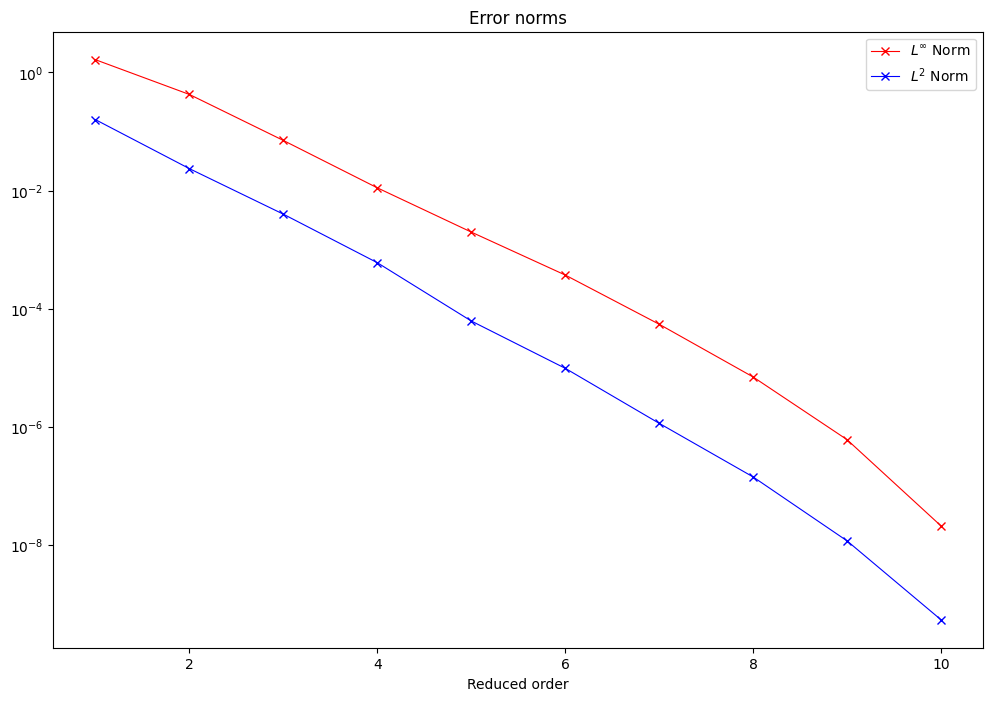

In [71]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.semilogy(order_list, linf_list, label = r"$L^\infty$ Norm", marker='x', color='red', lw = 0.8)
ax.semilogy(order_list, l2_list, label = r"$L^2$ Norm", marker='x', color='blue', lw = 0.8)
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()

### Complex-valued training and validation set (A Vital Step for IRKA)
In this section, we will examine the Matrix Reduction method using a complex-valued training set and validation set for complex parameters. For the IRKA method, we need to compute matrices at complex-valued interpolation points, and we will check if it works for complex parameters as well. As an example, we will again use `penzl_example` from `pymor.models.examples`.

In [47]:
from pymor.parameters.base import Mu

# Create an imaginary training set
card_training_set = 30
complex_parameters_training = 10*np.random.random_sample((card_training_set,)) + 10*1j*np.random.random_sample((card_training_set,))
imaginary_training_set = []

for i in range(card_training_set):
    imaginary_training_set.append(Mu({'s': np.array(complex_parameters_training[i])}))

# Create a validation set
card_validation_set = 10
complex_parameters_validation = 15*np.random.random_sample((card_training_set,)) + 15*1j*np.random.random_sample((card_training_set,))
imaginary_validation_set = []

for i in range(card_validation_set):
    imaginary_validation_set.append(Mu({'s': np.array(complex_parameters_validation[i])}))

print(f'An imaginary training set is {imaginary_training_set}.')
print(f'An imaginary validation set is {imaginary_validation_set}.')

An imaginary training set is [Mu({'s': array(1.34558586+2.93659197j)}), Mu({'s': array(8.05844747+4.2056032j)}), Mu({'s': array(7.08296493+5.5145707j)}), Mu({'s': array(7.59050175+9.47098749j)}), Mu({'s': array(9.46135433+0.98438216j)}), Mu({'s': array(9.96258884+4.82191358j)}), Mu({'s': array(2.96664858+8.0922364j)}), Mu({'s': array(4.15193175+8.014677j)}), Mu({'s': array(0.8330084+5.84345011j)}), Mu({'s': array(2.56815041+6.54612153j)}), Mu({'s': array(8.42831016+7.3700454j)}), Mu({'s': array(0.71346068+3.96832021j)}), Mu({'s': array(8.46369378+4.70860856j)}), Mu({'s': array(5.40423529+4.45134269j)}), Mu({'s': array(7.24516959+7.4058801j)}), Mu({'s': array(3.31735267+4.42845169j)}), Mu({'s': array(8.63661868+3.09923175j)}), Mu({'s': array(5.21894437+5.0676271j)}), Mu({'s': array(4.3705362+6.72635339j)}), Mu({'s': array(1.16384177+8.61184988j)}), Mu({'s': array(7.75789752+8.52962149j)}), Mu({'s': array(7.67693591+2.3312145j)}), Mu({'s': array(7.01695444+8.53800049j)}), Mu({'s': array(

In [50]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
A = penzl.A
B = penzl.B
dim = penzl.order

reduced_order_complex = 20

# Reduced solution
[reduced_solution, pod_reductor] = MatrixPODReductor(A, B, dim, imaginary_training_set, imaginary_validation_set, reduced_order = reduced_order_complex)

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Nice! Also the construction using complex valued parameters works. Not lets examine the error we obtain: 

In [68]:
# # Converting matrices to numpy arrays
# matrixA = to_matrix(penzl.A).toarray()
# matrixB = to_matrix(penzl.B)

# # Create a NumPy array containing parameters
# s_values = np.array([s['s'] for s in imaginary_validation_set]) 

# # Identity matrix of appropriate size
# identity = np.eye(penzl.order)

# # Exact solution
# exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

fom_solution_complex_validation = model_penzl.solution_space.empty()
for s in imaginary_validation_set: 
    fom_solution_complex_validation.append(model_penzl.solve(s))

# Data
order_list = np.arange(1, reduced_order_complex + 1)
linf_list = np.zeros(reduced_order_complex)
l2_list = np.zeros(reduced_order_complex)

for i in range(reduced_order_complex):
    [reduced_solution, pod_reductor] = MatrixPODReductor(A, B, dim, imaginary_training_set, imaginary_validation_set, reduced_order = i+1)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
    linf_list[i] = np.linalg.norm(fom_solution_complex_validation.to_numpy() - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(fom_solution_complex_validation.to_numpy() - reduced_solution_reconstruct_numpy, 2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

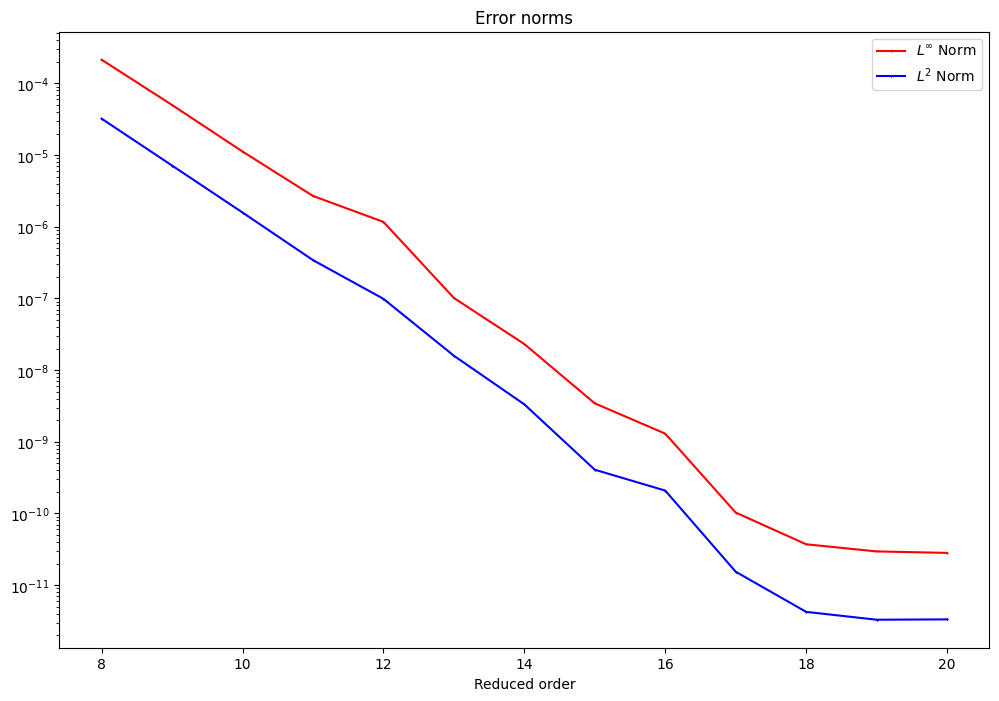

In [69]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.semilogy(order_list[7:], linf_list[7:], label = r"$L^\infty$ Norm", marker='x', color='red', ms = 0.8)
ax.semilogy(order_list[7:], l2_list[7:], label = r"$L^2$ Norm", marker='x', color='blue', ms = 0.9)
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()

### Hooray!🎉 It also seems to handle complex parameters
Let us check the $L_{\infty}$ and $L_{2}$ norms for complex parameters to explicitly see the error values.